In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
%matplotlib inline

from scipy.stats import boxcox
from scipy.stats.mstats import normaltest

from sklearn.preprocessing import StandardScaler,LabelEncoder,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
salary_df = pd.read_csv("clean_data.csv")

In [3]:
salary_df.head()

,Unnamed: 0,ResponseId,EdLevel,YearsCodePro,OrgSize,Country,Age,Gender,WorkExp,Salary,WorkExp_Group
0,0,13.0,0,2.236068,3,3,1,0,2.236068,11.082143,2
1,1,26.0,1,3.000000,3,0,1,0,3.000000,11.414728,3
2,2,54.0,0,3.162278,4,3,1,0,3.464102,12.043554,4
3,3,56.0,1,2.236068,4,3,1,2,2.236068,11.856515,2
4,4,77.0,1,4.472136,2,3,2,0,5.196152,11.982929,4


In [4]:
salary_df.shape

(3480, 11)

In [5]:
salary_df.set_index(['ResponseId'],inplace = True)

## Splitting Data

In [6]:
X = salary_df.drop(['Salary','WorkExp_Group','Unnamed: 0'], axis =1)
X.head()

,EdLevel,YearsCodePro,OrgSize,Country,Age,Gender,WorkExp
ResponseId,,,,,,,
13.0,0,2.236068,3,3,1,0,2.236068
26.0,1,3.000000,3,0,1,0,3.000000
54.0,0,3.162278,4,3,1,0,3.464102
56.0,1,2.236068,4,3,1,2,2.236068
77.0,1,4.472136,2,3,2,0,5.196152


In [7]:
y = salary_df.Salary
y

ResponseId
13.0       11.082143
26.0       11.414728
54.0       12.043554
56.0       11.856515
77.0       11.982929
             ...    
73010.0    10.756263
73070.0    11.635807
73103.0    13.309792
73117.0    11.652687
73120.0    11.156251
Name: Salary, Length: 3480, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=0)

## Feature Scaling

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [10]:
X_test = scaler.transform(X_test)

## Linear Regression

In [11]:
def  plot_dis(y,yhat):
    
    plt.figure()
    ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Salary (in dollars)')
    plt.ylabel('Proportion of Salary')

    plt.show()
    plt.close()

In [12]:
lm = LinearRegression()
lm.fit(X_train,y_train)
    

LinearRegression()

In [13]:
salary_prediction = lm.predict(X_test)
salary_prediction

array([12.06821363, 11.15891   , 11.250618  , ..., 11.02409673,
       11.76542968, 11.70448133])

In [14]:
mse = mean_squared_error(y_test, salary_prediction)
mse

0.2704277708603118

In [15]:
lm.score(X_test,y_test)

0.36732869531410095

In [16]:
r2_score(y_test,salary_prediction)

0.36732869531410095

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


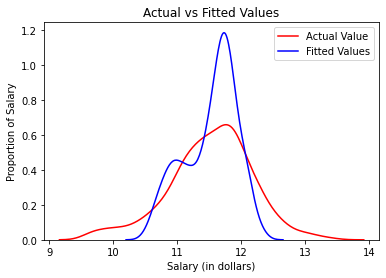

In [17]:
plot_dis(y_test,salary_prediction)

### Using Pipeline Object

In [18]:
steps=[('scaler', StandardScaler()), ('lm',  LinearRegression())]
pipe = Pipeline(steps=steps)
pipe.fit(X_train,y_train)
salary_prediction = pipe.predict(X_test)
mse = mean_squared_error(y_test, salary_prediction)
rmse = np.sqrt(mse)
rmse

0.5200267020647226

In [19]:
r2_score(salary_prediction, y_test)

-0.5779440530958793

### Using KFold

In [20]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [21]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 0  2  3  4  5  7  8  9 10 11] 2320
Test index: [ 1  6 14 15 17 18 21 22 23 30] 1160

Train index: [ 0  1  4  6  7  8 10 11 12 13] 2320
Test index: [ 2  3  5  9 16 19 20 24 26 27] 1160

Train index: [ 1  2  3  5  6  9 14 15 16 17] 2320
Test index: [ 0  4  7  8 10 11 12 13 25 28] 1160



In [22]:
estimator = Pipeline([("scaler", scaler),
                      ("regression", LinearRegression())])

In [23]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [24]:
salary_prediction_cv = cross_val_predict(estimator, X, y, cv=kf)
salary_prediction_cv

array([11.66796107, 10.90658691, 11.78904552, ..., 11.37949226,
       11.93313331, 11.46021625])

In [25]:
r2_score(y, salary_prediction_cv)

0.3577419008825664

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


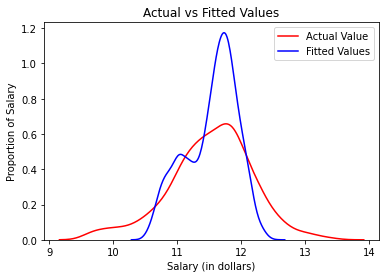

In [26]:
plot_dis(y_test,salary_prediction_cv)

### Grid Search CV

In [27]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [28]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [29]:
grid.best_score_, grid.best_params_

(0.47550497045121337,
 {'polynomial_features__degree': 3, 'ridge_regression__alpha': 20.0})

In [30]:
salary_prediction_grid = grid.predict(X)
salary_prediction_grid

array([11.71822869, 11.29474913, 11.99494207, ..., 11.11459034,
       11.96720646, 11.56162743])

In [31]:
r2_score(y, salary_prediction_grid)

0.5249955776914912

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


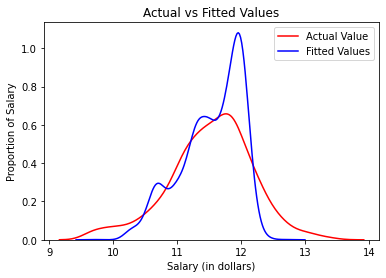

In [32]:
plot_dis(y_test,salary_prediction_grid)

### Polynominal Features

In [33]:
poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)
salary_prediction_poly = lm.predict(X_train_poly)
print("R^2 on training data:", lm.score(X_train_poly, y_train))
print("R^2 on testing data:", lm.score(X_test_poly,y_test))

R^2 on training data: 0.8372739548189516
R^2 on testing data: -3630511076030689.0


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


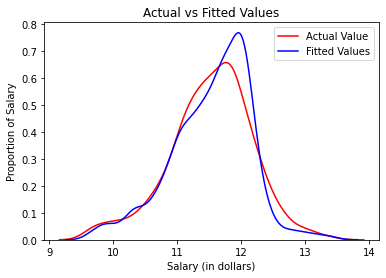

In [34]:
plot_dis(y_test,salary_prediction_poly)

### Ridge Regression

In [35]:
rr = Ridge(alpha=0.01)
rr

Ridge(alpha=0.01)

In [36]:
rr.fit(X_train, y_train)

Ridge(alpha=0.01)

In [37]:
salary_prediction_ridge = rr.predict(X_test)
print("R^2 on training  data ",rr.score(X_train, y_train))
print("R^2 on testing data ",rr.score(X_test,y_test))

R^2 on training  data  0.35968174470868697
R^2 on testing data  0.3673288562324919


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


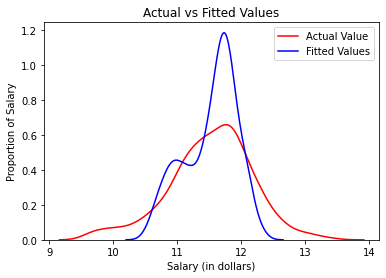

In [38]:
plot_dis(y_test,salary_prediction_ridge)

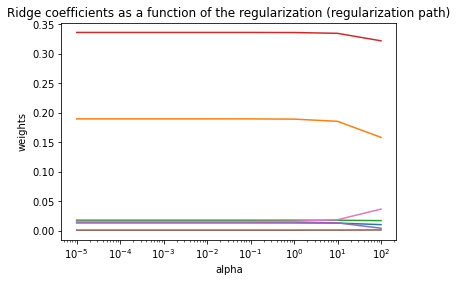

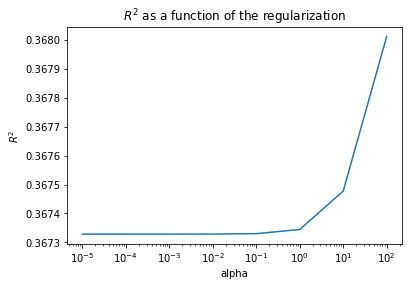

In [39]:
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
R_2=[]
coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefs.append(abs(ridge.coef_))
    R_2.append(ridge.score(X_test,y_test))


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization (regularization path)")
plt.show()


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()          

In [40]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=10)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
pipe = Pipeline(Input)

In [41]:
pipe.fit(X_train, y_train)
salary_prediction_ridge = pipe.predict(X_test)
pipe.score(X_test, y_test)

-356.4173397116765

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


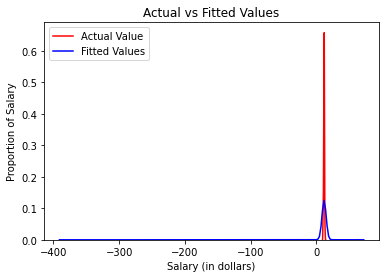

In [42]:
plot_dis(y_test,salary_prediction_ridge)

In [43]:
param_grid = {
    "polynomial__degree": [5, 10, 2, 7],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10,100]
}

In [44]:
search = GridSearchCV(pipe, param_grid, n_jobs=2)

search.fit(X_test, y_test)
search

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(degree=10,
                                                           include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Ridge(alpha=1))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'polynomial__degree': [5, 10, 2, 7]})

In [45]:
pd.DataFrame(search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_polynomial__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.321829,0.234976,0.009374,0.007654,0.0001,5,"{'model__alpha': 0.0001, 'polynomial__degree': 5}",-17466.481861,-2865.809972,-99.735961,-75.352019,-1.287937e+03,-4.359063e+03,6.632618e+03,22
1,1.892542,0.066522,0.137493,0.006249,0.0001,10,"{'model__alpha': 0.0001, 'polynomial__degree':...",-12536.042744,-10262.989827,-3693.989700,-3134.793666,-6.154875e+07,-1.231568e+07,2.461654e+07,28
2,0.009374,0.007654,0.000000,0.000000,0.0001,2,"{'model__alpha': 0.0001, 'polynomial__degree': 2}",0.474186,0.508603,0.519545,0.397021,4.080436e-01,4.614798e-01,5.052525e-02,6
3,0.424750,0.018069,0.031249,0.000004,0.0001,7,"{'model__alpha': 0.0001, 'polynomial__degree': 7}",-6281.678502,-6891.418415,-1312.887243,-1877.906823,-7.078080e+04,-1.742894e+04,2.677044e+04,25
4,0.146866,0.012499,0.012498,0.006249,0.001,5,"{'model__alpha': 0.001, 'polynomial__degree': 5}",-5640.081115,-229.132746,-13.273679,-28.907997,-1.019746e+03,-1.386228e+03,2.158507e+03,19


In [46]:
print("best_score_: ",search.best_score_)
print("best_params_: ",search.best_params_)

best_score_:  0.463098110507344
best_params_:  {'model__alpha': 10, 'polynomial__degree': 2}


In [47]:
salary_prediction_ridge = search.predict(X_test)
salary_prediction_ridge

array([12.04441733, 10.6582596 , 10.96535594, ..., 10.61335799,
       11.95141791, 11.80836846])

In [48]:
best=search.best_estimator_
best

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Ridge(alpha=10))])

In [49]:
salary_prediction_ridge = best.predict(X_test)
salary_prediction_ridge

array([12.04441733, 10.6582596 , 10.96535594, ..., 10.61335799,
       11.95141791, 11.80836846])

In [50]:
best.score(X_test, y_test)

0.5045448299395323

In [51]:
best.fit(X,y)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Ridge(alpha=10))])

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


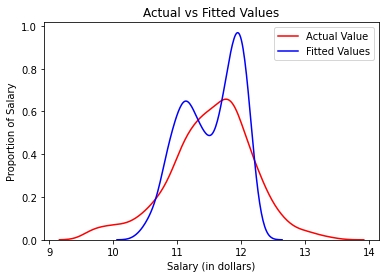

In [52]:
plot_dis(y_test,salary_prediction_ridge)

### Lasso Regression

In [53]:
la = Lasso(alpha=0.1)
la.fit(X_train,y_train)
la

Lasso(alpha=0.1)

In [54]:
salary_prediction_lasso = la.predict(X_test)
salary_prediction_lasso

array([11.87083354, 11.33107132, 11.31317718, ..., 11.19879399,
       11.70907128, 11.67615069])

In [55]:
print("R^2 on training  data ",la.score(X_train, y_train))
print("R^2 on testing data ",la.score(X_test,y_test))

R^2 on training  data  0.32001401425538345
R^2 on testing data  0.3336250178447252


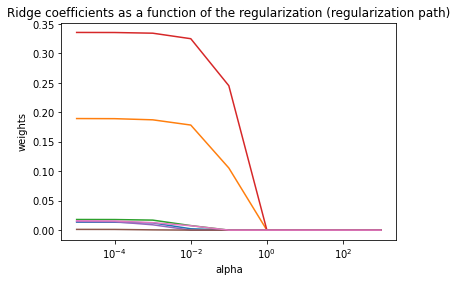

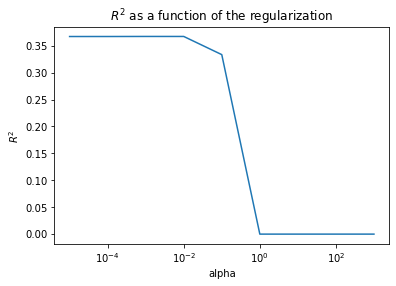

In [56]:
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
R_2=[]
coefs = []
for alpha in alphas:
    la=Lasso(alpha=alpha)
    
    la.fit(X_train, y_train)
    coefs.append(abs(la.coef_))
    R_2.append(la.score(X_test,y_test))


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization (regularization path)")
plt.show()


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()

In [57]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=10)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.2))]
pipe = Pipeline(Input)

In [58]:
pipe.fit(X_train, y_train)
salary_prediction_lasso = pipe.predict(X_test)

In [59]:
print("R^2 on training  data ",pipe.score(X_train, y_train))
print("R^2 on testing data ",pipe.score(X_test,y_test))

R^2 on training  data  0.0
R^2 on testing data  -0.0003950521704449983


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


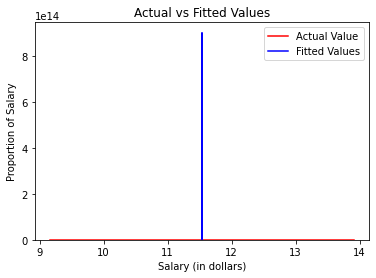

In [60]:
plot_dis(y_test,salary_prediction_lasso)

In [61]:
param_grid = {
    "polynomial__degree": [5, 10, 2, 7],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10,100]
}

In [62]:
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_test, y_test)

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(degree=10,
                                                           include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Lasso(alpha=1, tol=0.2))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'polynomial__degree': [5, 10, 2, 7]})

In [63]:
best=search.best_estimator_
best

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()),
                ('model', Lasso(alpha=0.0001, tol=0.2))])

In [64]:
best.score(X_test,y_test)

0.5056430457889414

### Elastic Net

In [65]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
enet.fit(X_train,y_train)

ElasticNet(alpha=0.1)

In [66]:
salary_prediction_elastic = enet.predict(X_test)
salary_prediction_elastic

array([11.94860331, 11.25655033, 11.28980246, ..., 11.12638603,
       11.72662763, 11.67802829])

In [67]:
print("R^2 on training  data ", enet.score(X_train, y_train))
print("R^2 on testing data ", enet.score(X_test,y_test))

R^2 on training  data  0.3445659182146338
R^2 on testing data  0.35692177207912656


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


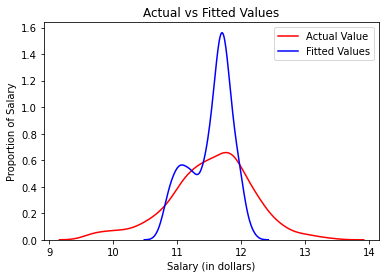

In [68]:
plot_dis(y_test,salary_prediction_elastic)

In [73]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=11)),('ss',StandardScaler() ), ('model',ElasticNet(alpha=0.1, l1_ratio=0.1))]
pipe = Pipeline(Input)
pipe.fit(X_train, y_train)
print("R^2 on training  data ",pipe.score(X_train, y_train))
print("R^2 on testing data ",pipe.score(X_test,y_test))

R^2 on training  data  0.482495083823012
R^2 on testing data  0.4047172969224502


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


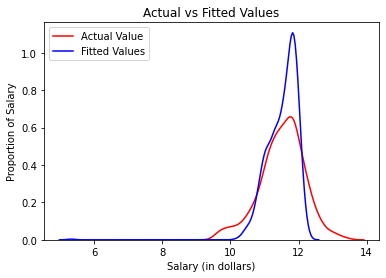

In [74]:
salary_prediction_elastic = pipe.predict(X_test)
plot_dis(y_test,salary_prediction_elastic)

In [108]:

Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=3)),('ss',StandardScaler() ), ('model',ElasticNet(alpha=0.001, l1_ratio=0.1, tol=0.2))]
pipe = Pipeline(Input)
pipe.fit(X_train, y_train)
print("R^2 on training  data ",pipe.score(X_train, y_train))
print("R^2 on testing data ",pipe.score(X_test,y_test))

R^2 on training  data  0.5234076424920145
R^2 on testing data  0.5087760631653213


C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


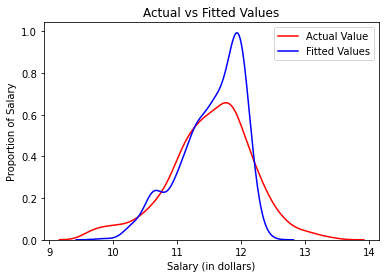

In [109]:
salary_prediction_elastic = pipe.predict(X_test)
plot_dis(y_test,salary_prediction_elastic)

In [110]:
param_grid = {
    "polynomial__degree": [3,2,5,10,7],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10,100],
    "model__l1_ratio":[0.1,0.25,0.5,0.75,0.9]
}

In [111]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=3)),('ss',StandardScaler() ), ('model',ElasticNet(tol = 0.2))]
pipe = Pipeline(Input)
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_test, y_test)
best=search.best_estimator_
best.score(X_test,y_test)


0.5056169139521667

In [112]:
best

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()),
                ('model', ElasticNet(alpha=0.001, l1_ratio=0.1, tol=0.2))])

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


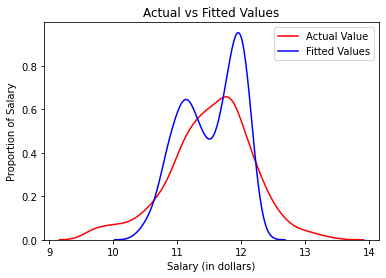

In [113]:
salary_prediction_elastic = best.predict(X_test)
plot_dis(y_test,salary_prediction_elastic)

In [116]:
search = GridSearchCV(pipe, param_grid, n_jobs=2)

search.fit(X_test, y_test)
search

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', ElasticNet(tol=0.2))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'model__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'polynomial__degree': [3, 2, 5, 10, 7]})

In [117]:
print("best_score_: ",search.best_score_)
print("best_params_: ",search.best_params_)

best_score_:  0.4641189190648161
best_params_:  {'model__alpha': 0.001, 'model__l1_ratio': 0.1, 'polynomial__degree': 2}


In [118]:
salary_prediction_elastic = best.predict(X_test)
salary_prediction_elastic

array([12.06630002, 10.63527687, 10.94764486, ..., 10.60735342,
       11.96786423, 11.82041902])

In [119]:
best.score(X_test, y_test)

0.5056169139521667

C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anchal\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


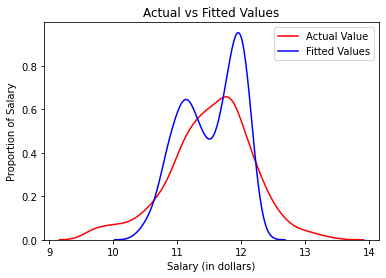

In [120]:
plot_dis(y_test,salary_prediction_elastic)